In [5]:
%reload_ext autoreload

from pathlib import Path
from IPython.display import display
import sys
from tqdm import tqdm

import pandas as pd
import numpy as np
import torch

sys.path.append("../..")
pd.set_option('display.max_columns', 50)

from neurosned.externalizing.feature_extractor import ExternalizingFeaturesExtractor
from neurosned.externalizing.ridge_model import RidgeModel
from neurosned.externalizing.knn import KnnModel
from neurosned.wrappers.challenge_2.predictor import ExternalizingPredictor


device = "cuda"
SFREQ = 100

In [6]:
import pickle
with open("../../artefacts/data/windows_ds_ch2_release_11.pkl", "rb") as f:
    train_raw_dataset = pickle.load(f)
train_raw_dataset.description

,subject,run,task,age,sex,p_factor,release_number,ehq_total,commercial_use,full_pheno,attention,internalizing,externalizing,restingstate,despicableme,funwithfractals,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,NDARAB678VYW,2,contrastChangeDetection,20.1817,M,0.887,R11,100.00,Yes,Yes,0.032,0.101,-0.825,available,available,available,available,available,available,available,available,available,available,unavailable,unavailable,available
1,NDARAB678VYW,1,contrastChangeDetection,20.1817,M,0.887,R11,100.00,Yes,Yes,0.032,0.101,-0.825,available,available,available,available,available,available,available,available,available,available,unavailable,unavailable,available
2,NDARAB678VYW,3,contrastChangeDetection,20.1817,M,0.887,R11,100.00,Yes,Yes,0.032,0.101,-0.825,available,available,available,available,available,available,available,available,available,available,unavailable,unavailable,available
3,NDARAB683CYD,1,contrastChangeDetection,7.2728,M,-1.487,R11,33.35,Yes,No,0.118,-0.648,-0.450,unavailable,caution,caution,caution,caution,caution,unavailable,unavailable,caution,unavailable,unavailable,unavailable,caution
4,NDARAC296UCB,1,contrastChangeDetection,22.0002,M,0.015,R11,80.04,Yes,No,-1.159,0.098,-0.668,caution,caution,unavailable,unavailable,caution,caution,caution,unavailable,caution,unavailable,unavailable,unavailable,caution
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,NDARZV406UFK,1,contrastChangeDetection,12.0888,M,-0.390,R11,93.34,Yes,Yes,-0.201,1.023,0.228,caution,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution
754,NDARZV406UFK,2,contrastChangeDetection,12.0888,M,-0.390,R11,93.34,Yes,Yes,-0.201,1.023,0.228,caution,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution
755,NDARZW623WYG,1,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution
756,NDARZW623WYG,2,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution


In [9]:
X = pd.read_csv('../../artefacts/data/externalizing_features.csv')
lag_features = [col for col in X.columns if 'lag' in col]
y = X.externalizing.values
X

,lag5_corr_mean_abs,lag5_corr_diag_mean,lag5_corr_off_mean,lag5_corr_entropy,lag5_A_mean_abs,lag5_A_diag_mean,lag5_A_off_mean,lag5_A_fro,lag5_A_asym_mean_abs,lag5_A_sparsity@0.05,lag10_corr_mean_abs,lag10_corr_diag_mean,lag10_corr_off_mean,lag10_corr_entropy,lag10_A_mean_abs,lag10_A_diag_mean,lag10_A_off_mean,lag10_A_fro,lag10_A_asym_mean_abs,lag10_A_sparsity@0.05,lag25_corr_mean_abs,lag25_corr_diag_mean,lag25_corr_off_mean,lag25_corr_entropy,lag25_A_mean_abs,...,lag25_A_asym_mean_abs,lag25_A_sparsity@0.05,lag50_corr_mean_abs,lag50_corr_diag_mean,lag50_corr_off_mean,lag50_corr_entropy,lag50_A_mean_abs,lag50_A_diag_mean,lag50_A_off_mean,lag50_A_fro,lag50_A_asym_mean_abs,lag50_A_sparsity@0.05,lag100_corr_mean_abs,lag100_corr_diag_mean,lag100_corr_off_mean,lag100_corr_entropy,lag100_A_mean_abs,lag100_A_diag_mean,lag100_A_off_mean,lag100_A_fro,lag100_A_asym_mean_abs,lag100_A_sparsity@0.05,externalizing,run_id,subject_id
0,0.951082,0.980879,0.950849,9.702513,0.009819,0.051711,0.007397,3.619800,0.006623,0.989183,0.945373,0.971120,0.945172,9.702464,0.011044,0.036333,0.007493,3.996084,0.010726,0.979148,0.927441,0.943449,0.927316,9.702115,0.014831,...,0.020712,0.926687,0.902249,0.908868,0.902197,9.702060,0.028371,0.016668,0.005194,8.679472,0.043221,0.853795,0.924926,0.929726,0.924889,9.703304,0.033544,-0.019226,0.008290,9.962540,0.045559,0.858843,-0.825,2,NDARAB678VYW
1,0.327422,0.492386,0.033992,9.512185,0.152468,0.057616,-0.004849,26.594938,0.222127,0.281113,0.162424,0.236548,0.016790,9.458664,0.159104,0.016264,0.000081,28.548531,0.233451,0.288024,0.132618,-0.039049,-0.008226,9.338587,0.166301,...,0.240891,0.261162,0.119016,-0.005705,0.004330,9.342669,0.144692,0.002698,-0.000378,25.491650,0.209972,0.283697,0.203108,-0.150608,0.007254,9.399150,0.119727,-0.005521,-0.003297,21.672873,0.177511,0.327444,-0.825,2,NDARAB678VYW
2,0.108066,0.055448,-0.011273,9.385655,0.174908,0.048511,-0.000870,30.171751,0.251096,0.252990,0.109994,0.070511,-0.000740,9.387965,0.184420,0.011912,-0.003097,31.683516,0.264340,0.236825,0.105150,-0.077316,-0.035612,9.359575,0.201535,...,0.287095,0.204855,0.091567,-0.010679,0.005457,9.313070,0.217440,0.000746,0.001014,37.404549,0.312117,0.200288,0.138767,0.031442,0.047782,9.375692,0.203083,0.005886,0.002894,34.192940,0.289493,0.201971,-0.825,2,NDARAB678VYW
3,0.347024,0.619068,0.071318,9.475776,0.124249,0.056296,0.003655,22.093390,0.182394,0.327324,0.193959,0.325690,0.046597,9.400247,0.137647,0.015836,-0.000391,24.902124,0.202340,0.290968,0.293658,-0.169244,-0.026652,9.432089,0.095987,...,0.138593,0.393306,0.188986,-0.098878,-0.027861,9.350086,0.078070,0.005690,-0.002537,14.609133,0.117120,0.496605,0.157806,-0.156264,-0.009905,9.391450,0.066476,-0.004820,-0.004996,12.479653,0.097762,0.552731,-0.825,2,NDARAB678VYW
4,0.610808,0.718880,0.099228,9.582117,0.113912,0.048651,-0.002917,20.528034,0.165570,0.331170,0.442212,0.476169,0.076493,9.563319,0.160784,0.024103,-0.003896,29.111073,0.235642,0.261282,0.194065,-0.062057,0.027013,9.308769,0.242803,...,0.349553,0.176011,0.144114,-0.038031,0.013525,9.277909,0.255856,-0.007981,0.003204,48.036694,0.380293,0.204194,0.392749,0.257060,0.092801,9.521448,0.249158,-0.001962,0.001207,42.820286,0.364203,0.159065,-0.825,2,NDARAB678VYW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,0.191560,0.377069,0.028909,9.394187,0.149076,0.058960,0.000445,25.162123,0.211610,0.249504,0.175802,0.324459,0.040964,9.404029,0.163181,0.019962,-0.003137,27.953690,0.232667,0.236524,0.172610,0.127398,0.003355,9.419593,0.159927,...,0.228438,0.231176,0.180337,-0.053033,-0.063342,9.408302,0.189892,0.008285,0.000632,32.330307,0.273482,0.209062,0.182795,-0.161491,-0.048521,9.370559,0.213447,-0.013885,-0.001018,35.959003,0.305176,0.185385,-0.309,3,NDARZW623WYG
6913,0.196202,0.369043,0.128164,9.387654,0.157255,0.045318,0.000568,26.566793,0.223333,0.24241

## Stratified Split by Mean and Std of target

In [67]:
# Split train/test by subject_id (80%/20%)
subject_ids = X['subject_id'].unique()
n_train = int(len(subject_ids) * 0.8)

best_split = None
best_diff = np.inf

np.random.seed(142)
progress_bar = tqdm(range(10000))
for trial in progress_bar:
    train_subjects = np.random.choice(subject_ids, size=n_train, replace=False)
    test_subjects = np.setdiff1d(subject_ids, train_subjects)

    y_train = X.loc[X.subject_id.isin(train_subjects), 'externalizing'].values
    y_test = X.loc[X.subject_id.isin(test_subjects), 'externalizing'].values

    avg_train, std_train = y_train.mean(), y_train.std()
    avg_test, std_test = y_test.mean(), y_test.std()
    diff = abs(avg_train - avg_test) * 10 + abs(std_train - std_test)

    if best_split is None or diff < best_diff:
        best_diff = diff
        best_split = {
            'train_subjects': train_subjects,
            'test_subjects': test_subjects,
            'avg_train': avg_train,
            'avg_test': avg_test,
            'std_train': std_train,
            'std_test': std_test,
        }
        progress_bar.set_postfix_str(f'best_diff: {best_diff:.6}')
# Use the best split
X_train = X.loc[X.subject_id.isin(best_split['train_subjects']), :]
X_test = X.loc[X.subject_id.isin(best_split['test_subjects']), :]
y_train = X.loc[X.subject_id.isin(best_split['train_subjects']), 'externalizing']
y_test = X.loc[X.subject_id.isin(best_split['test_subjects']), 'externalizing']

print(f"Best split - Train avg/std: {best_split['avg_train']:.4f}/{best_split['std_train']:.4f}, "
      f"Test avg/std: {best_split['avg_test']:.4f}/{best_split['std_test']:.4f}")

100%|██████████| 10000/10000 [00:08<00:00, 1168.70it/s, best_diff: 0.00478956]

Best split - Train avg/std: -0.0913/0.6799, Test avg/std: -0.0909/0.6810


## Correlations: really depends from sample

That is why important to find the split between train and test that keep at least major statistics: mean and std

In [68]:
import scipy.stats

corrs = {}
for col in X_train.columns:
    if col not in ('externalizing', 'subject_id'):
        corr, pval = scipy.stats.pearsonr(X_train[col], y_train)
        corrs[col] = {'corr': corr, 'pval': pval, 'corr_abs': abs(corr)}
        corr, pval = scipy.stats.pearsonr(X_test[col], y_test)
        corrs[col].update({'test_corr': corr, 'test_pval': pval, 'test_corr_abs': abs(corr)})
corrs = pd.DataFrame(corrs).T.sort_values('corr_abs', ascending=False)
corrs['mean_corr'] = (corrs['corr_abs'] + corrs['test_corr_abs']) / 2
corrs['min_corr'] = corrs[['corr_abs', 'test_corr_abs']].min(axis=1)
corrs = corrs.sort_values('min_corr', ascending=False)
corrs[['corr', 'corr_abs', 'test_corr_abs', 'min_corr']].head(30)

,corr,corr_abs,test_corr_abs,min_corr
lag5_corr_entropy,-0.063217,0.063217,0.150405,0.063217
lag100_corr_entropy,-0.058938,0.058938,0.110948,0.058938
lag10_corr_entropy,-0.058003,0.058003,0.117888,0.058003
lag50_corr_entropy,-0.053672,0.053672,0.120290,0.053672
lag5_corr_diag_mean,0.053627,0.053627,0.098426,0.053627
lag10_corr_diag_mean,0.047246,0.047246,0.098469,0.047246
lag25_corr_mean_abs,0.059823,0.059823,0.039993,0.039993
lag25_corr_diag_mean,0.039318,0.039318,0.053293,0.039318
lag100_A_diag_mean,-0.033145,0.033145,0.119589,0.033145
lag100_A_mean_abs,-0.037645,0.037645,0.030981,0.030981


## Feature Selection

### Building the feature pool
1. Compute all correlation- and transition-matrix features on 2-s windows (sfreq = 100 Hz; per-channel standardized).
2. Rank features by **absolute Pearson correlation** with the externalizing score on training subjects.
3. Keep the **top-ranked features** as the initial **feature pool** for selection.

### Subject split
We split subjects so that the **mean and std of the target** are closely matched across folds/partitions (subject-level split; no leakage across sessions/runs).  
**The test partition is fixed** and never resampled.

### Bootstrap-driven feature selection
We run a stochastic, bootstrap-validated add/drop search:

1. **Initialize** with top correlated with target features.
2. **Bootstrap training subjects** (with replacement). For each bootstrap, draw multiple random **crops per subject**, fit a Ridge model on the bootstrap set, and **predict the fixed test partition**.
3. Collect **NRMSE** over \(B\) bootstraps; compute the **median** and estimate the **CI width**.  
   *Goal:* **minimize CI width**; in practice we use **STD(NRMSE)** as a proxy for CI width.
4. **Acceptance rule:** a candidate subset is **better** if it **improves the median NRMSE** *and* **reduces STD(NRMSE)** (i.e., narrows the confidence interval) on test subjects.
5. **Move step:** randomly **drop** one feature from the current subset *or* **add** one from the pool; repeat steps 2–4 until no improvement for several iterations.

The procedure converged to the **feature set listed above**, and we saved the **best Ridge** weights for downstream use.

> Outcome: the bootstrap criterion favors subsets that are both **accurate** and **stable**, yielding a calibrated, generalizable ridge model on R11.



In [ ]:
from IPython.display import clear_output
import io
import contextlib


def _bootstrap_sample_subjects(
    df: pd.DataFrame,
    usecols,
    crops_per_subject: int,
    subject_col: str = 'subject_id',
    target_col: str = 'externalizing',
):
    """Sample subjects with replacement; per subject sample `crops_per_subject` rows with replacement."""
    feats = []
    targets = []

    subjects = df[subject_col].unique()
    bs_subjects = np.random.choice(subjects, size=len(subjects), replace=True)

    for sid in bs_subjects:
        sub_df = df[df[subject_col] == sid]
        if len(sub_df) == 0:
            continue
        take = [random.randrange(len(sub_df)) for _ in range(crops_per_subject)]  # with replacement
        sub_pick = sub_df.iloc[take]
        feats.append(sub_pick[list(usecols)])
        targets.append(sub_pick[target_col])

    Xb_df = pd.concat(feats, ignore_index=True) if feats else pd.DataFrame(columns=usecols)
    yb = pd.concat(targets, ignore_index=True) if targets else pd.Series(dtype=float)
    return Xb_df, yb

def bootstrap_eval_selection(X_train, X_test, usecols, n_samples=10):
    clip_low, clip_high = None, None
    scores = []
    sink = io.StringIO()

    for _ in range(n_samples):
        X_b, y_b =_bootstrap_sample_subjects(X_train, current_usecols, crops_per_subject=3)
        with contextlib.redirect_stdout(sink), contextlib.redirect_stderr(sink):
            ridge_model = RidgeModel.make_checkpoint(
                X_b, y_b, usecols=usecols, C=1, force_bias=y_train.mean(), save_path='tmp.pt'
            )
        nrmse_test = ridge_model.eval_df(X_test, y_test, clip_low=clip_low, clip_high=clip_high)
        scores.append(nrmse_test)
    return np.median(nrmse_test), np.std(nrmse_test)

def eval_selection(X_train, X_test, usecols, n_samples=10):
    clip_low, clip_high = None, None
    sink = io.StringIO()  
    with contextlib.redirect_stdout(sink), contextlib.redirect_stderr(sink):
        ridge_model = RidgeModel.make_checkpoint(
            X_train, X_train.externalizing, usecols=usecols, C=1,
            force_bias=X_train["externalizing"].mean(),
            save_path="tmp.pt"
        )
    nrmse_train = ridge_model.eval_df(
        X_train, X_train["externalizing"],
        clip_low=clip_low, clip_high=clip_high
    )
    nrmse_test = ridge_model.eval_df(
        X_test, X_test["externalizing"],
        clip_low=clip_low, clip_high=clip_high
    )
    return ridge_model, nrmse_train, nrmse_test

In [ ]:
demo_mode = True
n_iterations = 100 if demo_mode else 1000

choosen_usecols = corrs.index.tolist()[:25]
current_usecols = choosen_usecols.copy()
best_score, best_std = bootstrap_eval_selection(X_train, X_test, usecols=current_usecols)

for attempt in tqdm(range(n_iterations)):
    col_to_remove = np.random.choice(choosen_usecols)
    current_usecols = [col for col in choosen_usecols if col != col_to_remove]
    nrmse_score, nrmse_std = bootstrap_eval_selection(X_train, X_test, usecols=current_usecols)
    if nrmse_score < best_score and nrmse_std < best_std:
        choosen_usecols = current_usecols
        best_score = nrmse_score
        best_std = nrmse_std

    
    col_to_add = np.random.choice([col for col in lag_features if col not in choosen_usecols])
    current_usecols = choosen_usecols + [col_to_add]
    nrmse_score, nrmse_std = bootstrap_eval_selection(X_train, X_test, usecols=current_usecols)
    if nrmse_score < best_score and nrmse_std < best_std:
        choosen_usecols = current_usecols
        best_score = nrmse_score
        best_std = nrmse_std

clear_output()
print(choosen_usecols)
ridge_model, nrmse_train, nrmse_test = eval_selection(X_train, X_test, usecols=current_usecols)
print(f"Train NRMSE: {nrmse_train:.4f}, Test NRMSE: {nrmse_test:.4f}")
clip_low, clip_high = None, None
train_preds = ridge_model.forward_df(X_train, clip_low=clip_low, clip_high=clip_high)
test_preds = ridge_model.forward_df(X_test, clip_low=clip_low, clip_high=clip_high)

['lag5_corr_entropy', 'lag100_corr_entropy', 'lag10_corr_entropy', 'lag50_corr_entropy', 'lag5_corr_diag_mean', 'lag10_corr_diag_mean', 'lag25_corr_mean_abs', 'lag25_corr_diag_mean', 'lag100_A_diag_mean', 'lag100_A_mean_abs', 'lag50_A_asym_mean_abs', 'lag25_corr_entropy', 'lag100_corr_mean_abs', 'lag50_corr_mean_abs', 'lag50_A_mean_abs', 'lag25_A_asym_mean_abs', 'lag25_A_mean_abs', 'lag100_A_asym_mean_abs', 'lag5_corr_off_mean', 'lag100_corr_diag_mean', 'lag100_corr_off_mean', 'lag50_A_sparsity@0.05', 'lag25_A_sparsity@0.05', 'lag10_corr_mean_abs', 'lag50_A_fro']
Train NRMSE: 0.9870, Test NRMSE: 0.9863


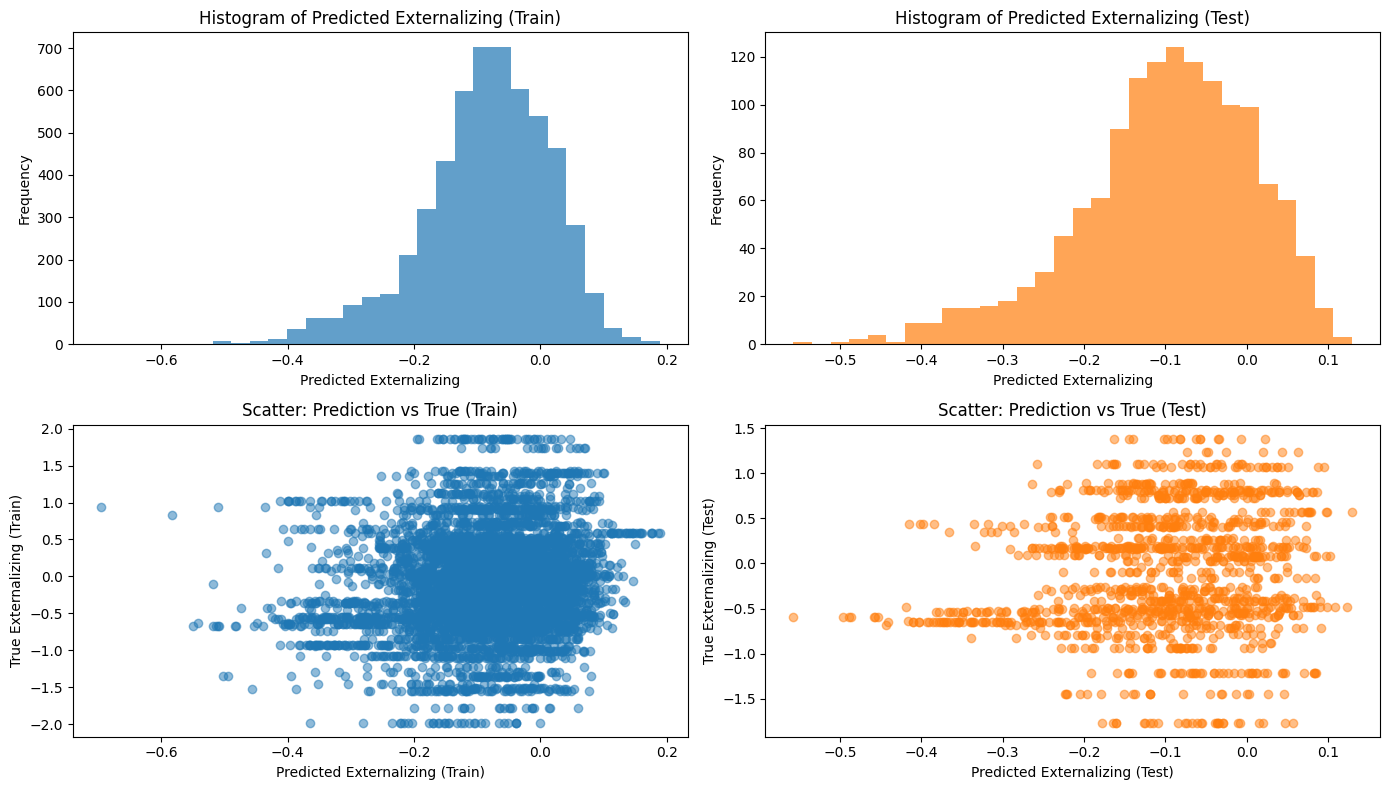

In [55]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14,8))

# Histograms
axes[0,0].hist(train_preds, bins=30, alpha=0.7, color='C0', label='Train')
axes[0,0].set_xlabel("Predicted Externalizing")
axes[0,0].set_ylabel("Frequency")
axes[0,0].set_title("Histogram of Predicted Externalizing (Train)")

axes[0,1].hist(test_preds, bins=30, alpha=0.7, color='C1', label='Test')
axes[0,1].set_xlabel("Predicted Externalizing")
axes[0,1].set_ylabel("Frequency")
axes[0,1].set_title("Histogram of Predicted Externalizing (Test)")

# Scatter plots
axes[1,0].scatter(train_preds, y_train, alpha=0.5, color='C0')
axes[1,0].set_xlabel("Predicted Externalizing (Train)")
axes[1,0].set_ylabel("True Externalizing (Train)")
axes[1,0].set_title("Scatter: Prediction vs True (Train)")

axes[1,1].scatter(test_preds, y_test, alpha=0.5, color='C1')
axes[1,1].set_xlabel("Predicted Externalizing (Test)")
axes[1,1].set_ylabel("True Externalizing (Test)")
axes[1,1].set_title("Scatter: Prediction vs True (Test)")

plt.tight_layout()
plt.show()


# Best solution found by procedure above

In [69]:
usecols  = [
            'lag10_corr_diag_mean',
            'lag10_corr_entropy',
            'lag25_corr_entropy',
            'lag100_A_diag_mean',
            'lag25_corr_diag_mean',
            'lag5_corr_diag_mean',
            'lag25_corr_mean_abs',
            'lag50_corr_mean_abs',
            'lag100_corr_entropy',
            'lag50_A_diag_mean',
            'lag5_corr_off_mean',
            'lag5_corr_entropy',
            'lag100_A_mean_abs',
            'lag50_corr_entropy',
            'lag100_A_asym_mean_abs',
            'lag100_A_fro',
            'lag50_corr_off_mean',
            'lag100_A_sparsity@0.05',
            'lag10_corr_mean_abs',
            'lag50_A_mean_abs',
            'lag5_A_off_mean',
            'lag25_A_mean_abs',
            'lag10_A_off_mean'
        ]
ridge_model = RidgeModel(usecols)
ridge_model.load_state_dict(torch.load('../../artefacts/models/challenge_2/short_ridge.pt')['state_dict'])

clip_low, clip_high = None, None

nrmse_train = ridge_model.eval_df(X_train, y_train, clip_low=clip_low, clip_high=clip_high)
nrmse_test = ridge_model.eval_df(X_test, y_test, clip_low=clip_low, clip_high=clip_high)
print(f"Train: {nrmse_train:.4f}, test: {nrmse_test:.4f}")

train_preds = ridge_model.forward_df(X_train, clip_low=clip_low, clip_high=clip_high)
test_preds = ridge_model.forward_df(X_test, clip_low=clip_low, clip_high=clip_high)

Train: 0.9939, test: 0.9794


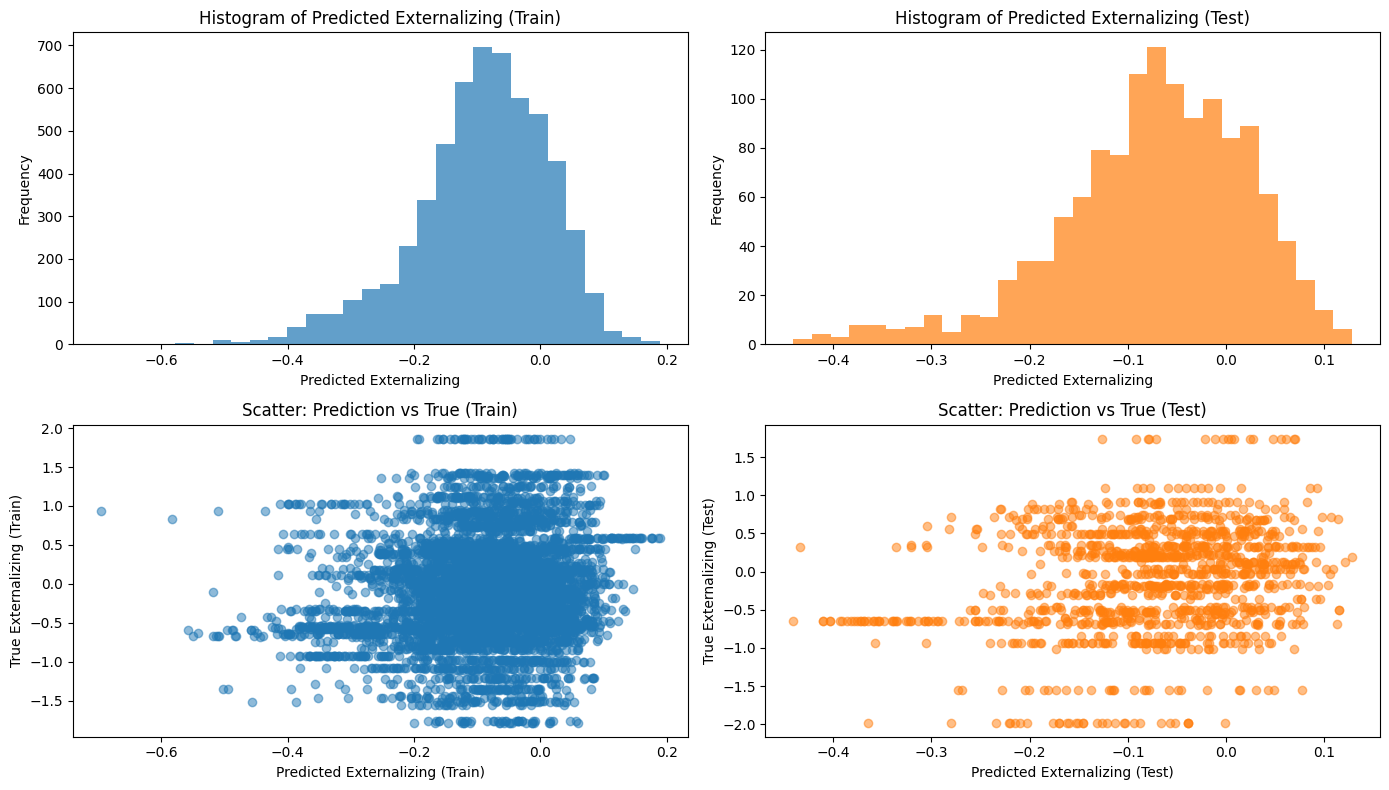

In [70]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14,8))

# Histograms
axes[0,0].hist(train_preds, bins=30, alpha=0.7, color='C0', label='Train')
axes[0,0].set_xlabel("Predicted Externalizing")
axes[0,0].set_ylabel("Frequency")
axes[0,0].set_title("Histogram of Predicted Externalizing (Train)")

axes[0,1].hist(test_preds, bins=30, alpha=0.7, color='C1', label='Test')
axes[0,1].set_xlabel("Predicted Externalizing")
axes[0,1].set_ylabel("Frequency")
axes[0,1].set_title("Histogram of Predicted Externalizing (Test)")

# Scatter plots
axes[1,0].scatter(train_preds, y_train, alpha=0.5, color='C0')
axes[1,0].set_xlabel("Predicted Externalizing (Train)")
axes[1,0].set_ylabel("True Externalizing (Train)")
axes[1,0].set_title("Scatter: Prediction vs True (Train)")

axes[1,1].scatter(test_preds, y_test, alpha=0.5, color='C1')
axes[1,1].set_xlabel("Predicted Externalizing (Test)")
axes[1,1].set_ylabel("True Externalizing (Test)")
axes[1,1].set_title("Scatter: Prediction vs True (Test)")

plt.tight_layout()
plt.show()
